# Best time to release review after tech event

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import datetime
import matplotlib.pyplot as plt
import pickle
import datetime
from IPython.display import Image

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from gensim import corpora, models
import gensim
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH_YT_METADATA = 'data/yt_metadata_en.jsonl'
ITEMS = ['iphone x', 'iphone 7', 'iphone 6', 'galaxy s9', 'galaxy note 9', 'galaxy fold']
RELEASE_DATES = {
    'iphone x': '2017-11-03',
    'iphone 7': '2016-09-16',
    'iphone 6': '2014-09-19',
    'galaxy s9': '2018-03-16',
    'galaxy note 9': '2018-08-24',
    'galaxy fold': '2019-02-01'
}

In [11]:
items_dfs = {k : [] for k in ITEMS}

In [12]:
# filter metadata
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags"], inplace=True, axis=1)
    df_json = df_json[df_json['categories'].isin(['Science & Technology', 'Education', 'Entertainment'])]
    df_json.drop(["categories"], inplace=True, axis=1)
    for item in ITEMS:
        df_item = df_json[df_json['title'].str.lower().str.contains(item)]
        df_item["upload_date"] = pd.to_datetime(df_item["upload_date"])
        df_item = df_item[(df_item['upload_date'] >= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') - datetime.timedelta(days=180)) & (df_item['upload_date'] <= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') + datetime.timedelta(days=180))]
        if len(df_item) > 0:
            items_dfs[item].append(df_item)

Loading data: 730it [08:59,  1.35it/s]                               


In [13]:
items_dfs = {k : pd.concat(v) for k, v in items_dfs.items()}

In [4]:
def get_sum_views(df):
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # remove rows with NaN
    df = df.dropna()


    # convert 'view_count' to int64
    df["view_count"] = df["view_count"].astype("int64")

    # keep only 'view_count' and 'upload_date'
    df = df[["view_count", "upload_date"]]
    df = df.groupby("upload_date").sum()

    # remove rows with NaN
    df = df.dropna()
    
    return df

In [5]:
def plot_views_per_day(df, item):
    plt.figure(figsize=(20,10))
    plt.bar(df.index, df["view_count"])
    plt.xlabel("Date")
    plt.ylabel("View Count")
    plt.title("{item} View Count Over Time".format(item=item))
    plt.show()

In [6]:
def tf_idf(tokens):
    """
    Given a list of tokens, compute the tf-idf coefficient for each token.
    :param tokens: list of titles split into tokens
    :return: dictionary of tf-idf coefficients
    """
    # create dictionary
    dictionary = corpora.Dictionary(tokens)
    
    # create corpus
    corpus = [dictionary.doc2bow(text) for text in tokens]
    
    # create tf-idf model
    tfidf = models.TfidfModel(corpus)
    
    # get tf-idf coefficients
    tfidf_weights = {}
    for doc in corpus:
        for id, weight in tfidf[doc]:
            tfidf_weights[dictionary[id]] = weight
    
    return tfidf_weights

In [7]:
def get_tf_idf_score(tf_idf_scores, words):
    """
    Given a dictionary of tf-idf scores and a list of words, compute the average tf-idf score for the list of words.
    :param tf_idf_scores: dictionary of tf-idf scores
    :param words: list of words
    :return: average tf-idf score for the list of words
    """
    score = 0
    for word in words:
        score += tf_idf_scores.get(word, 0)

    return score / len(words)

In [8]:
def score_per_day(df, item, release_date):
    """
    Given a product name, fetches the df for videos with titles containing the name of the product
    that were uploaded within 6 months of the product's release date and computes the total view count,
    total likes total dislikes and number of videos per day.
    :param item: product name
    :param df: dataframe of videos with titles containing the name of the product
    :return: dataframe of total view count, total likes total dislikes and number of videos per day
    """

    # filter out titles that do not contain the product name
    df = df[df["title"].str.lower().str.contains(item)]
    
    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # convert 'upload_date' to datetime
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # keep only rows that were uploaded within 3 months of the product's release date
    df = df[(df["upload_date"] >= release_date - datetime.timedelta(days=90)) & (df["upload_date"] <= release_date + datetime.timedelta(days=90))]

    # keep only 'view_count', 'upload_date', 'likes', 'dislikes', 'title'
    df = df[["view_count", "upload_date", "like_count", "dislike_count", "title"]]

    # group by 'upload_date'
    df = df.groupby("upload_date")

    # compute total view count, total like_count, total dislike_count and number of videos per day
    df = df.agg({"view_count": "sum", "like_count": "sum", "dislike_count": "sum", "title": "count"})

    return df

In [24]:
def plot_scores(scores_df, release_date, product_name):
    """
    Given a dataframe of view count, like count, dislike count and number of videos per day,
    plots the view count, like count, dislike count and number of videos per day over time.
    :param scores_df: dataframe of view count, like count, dislike count and number of videos per day
    :return: None
    """

    # plot the 3 curves in 3 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
    # bars sould have different colours according to the period (announcement, release, post-release)
    # announcement is around 2 months before release +- 1 month
    # release is +- 1 month around release date
    # post-release is 1 month after release date
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    axes[0, 0].bar(scores_df.index, scores_df["view_count"])
    axes[0, 0].set_title("View Count Over Time")
    axes[0, 0].set_xlabel("Date")
    axes[0, 0].set_ylabel("View Count")
    axes[0, 0].axvline(x=release_date, color="red", linestyle="dashed")
    axes[0, 1].bar(scores_df.index, scores_df["like_count"])
    axes[0, 1].set_title("Like Count Over Time")
    axes[0, 1].set_xlabel("Date")
    axes[0, 1].set_ylabel("Like Count")
    axes[0, 1].axvline(x=release_date, color="red", linestyle="dashed")
    axes[1, 0].bar(scores_df.index, scores_df["dislike_count"])
    axes[1, 0].set_title("Dislike Count Over Time")
    axes[1, 0].set_xlabel("Date")
    axes[1, 0].set_ylabel("Dislike Count")
    axes[1, 0].axvline(x=release_date, color="red", linestyle="dashed")
    axes[1, 1].bar(scores_df.index, scores_df["title"])
    axes[1, 1].set_title("Number of Videos Over Time")
    axes[1, 1].set_xlabel("Date")
    axes[1, 1].set_ylabel("Number of Videos")
    axes[1, 1].axvline(x=release_date, color="red", linestyle="dashed")
    fig.tight_layout(pad=3.0)
    fig.suptitle("Scores Over Time for {product_name}".format(product_name=product_name), fontsize=30)
    plt.show()
    
    

    # give a big title to the entire figure
    fig.suptitle("Scores Over Time for {product_name}".format(product_name=product_name), fontsize=30)
    plt.show()


In [10]:
def get_lda_topics(df, num_topics, num_words):
    # tokenize words
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df["title"].apply(tokenizer.tokenize)

    # convert to lowercase
    df["tokens"] = df["tokens"].apply(lambda x: [word.lower() for word in x])
    
    # remove stop words
    stop_words = stopwords.words('english')
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # remove words that appear only once
    all_tokens = sum(df["tokens"], [])
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in tokens_once])

    # remove the token 'iphone'
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word != "iphone"])

    # remove one character tokens
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if len(word) > 2])
    
    # create dictionary and corpus
    dictionary = corpora.Dictionary(df["tokens"])
    corpus = [dictionary.doc2bow(text) for text in df["tokens"]]
    
    # create LDA model
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    
    # print topics
    print("LDA Topics:")
    for topic in lda.print_topics(num_words=num_words):
        print(topic)
    
    # visualize topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    return vis

***
## 1- Impact of iPhone release on Youtube activity
***

### 1.1- iPhone X views vs YouTube views

In [12]:
yt_date_views = {}
iphone_date_views = {}
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags", "categories"], inplace=True, axis=1)

    item1 = 'iphone x'
    item2 = 'wwdc'

    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    df_json = df_json[(df_json['upload_date'] >= datetime.datetime.strptime(RELEASE_DATES[item1], '%Y-%m-%d') - datetime.timedelta(days=180)) & (df_json['upload_date'] <= datetime.datetime.strptime(RELEASE_DATES[item1], '%Y-%m-%d') + datetime.timedelta(days=180))]

    # filter out titles that do not contain item1 or item2
    df_item = df_json[df_json["title"].str.lower().str.contains(item1) | df_json["title"].str.lower().str.contains(item2)]

    item_views = get_sum_views(df_item)
    youtube_views = get_sum_views(df_json)

    # for each 'upload_date' in item_views, get the corresponding 'view_count' in youtube_views
    for date in item_views.index:
        if date in yt_date_views:
            yt_date_views[date] += youtube_views.loc[date]["view_count"]
            iphone_date_views[date] += item_views.loc[date]["view_count"]
        else:
            yt_date_views[date] = youtube_views.loc[date]["view_count"]
            iphone_date_views[date] = item_views.loc[date]["view_count"]

Loading data: 730it [08:27,  1.44it/s]                               


In [13]:
# convert dictionaries to dataframes
yt_date_views_df = pd.DataFrame.from_dict(yt_date_views, orient="index", columns=["view_count"])
iphone_date_views_df = pd.DataFrame.from_dict(iphone_date_views, orient="index", columns=["view_count"])

# merge dataframes on the 'upload_date' column
merged_df = pd.merge(yt_date_views_df, iphone_date_views_df, left_index=True, right_index=True)
merged_df = merged_df.rename(columns={"view_count_x": "youtube_view_count", "view_count_y": "iphone_view_count"})

# get the ratio of iphone views to youtube views
merged_df["ratio"] = merged_df["iphone_view_count"] / merged_df["youtube_view_count"]

In [21]:
# get the ratio of iphone views to youtube views
iphone_date_views_df["ratio"] = iphone_date_views_df["view_count"] / yt_date_views_df["view_count"]

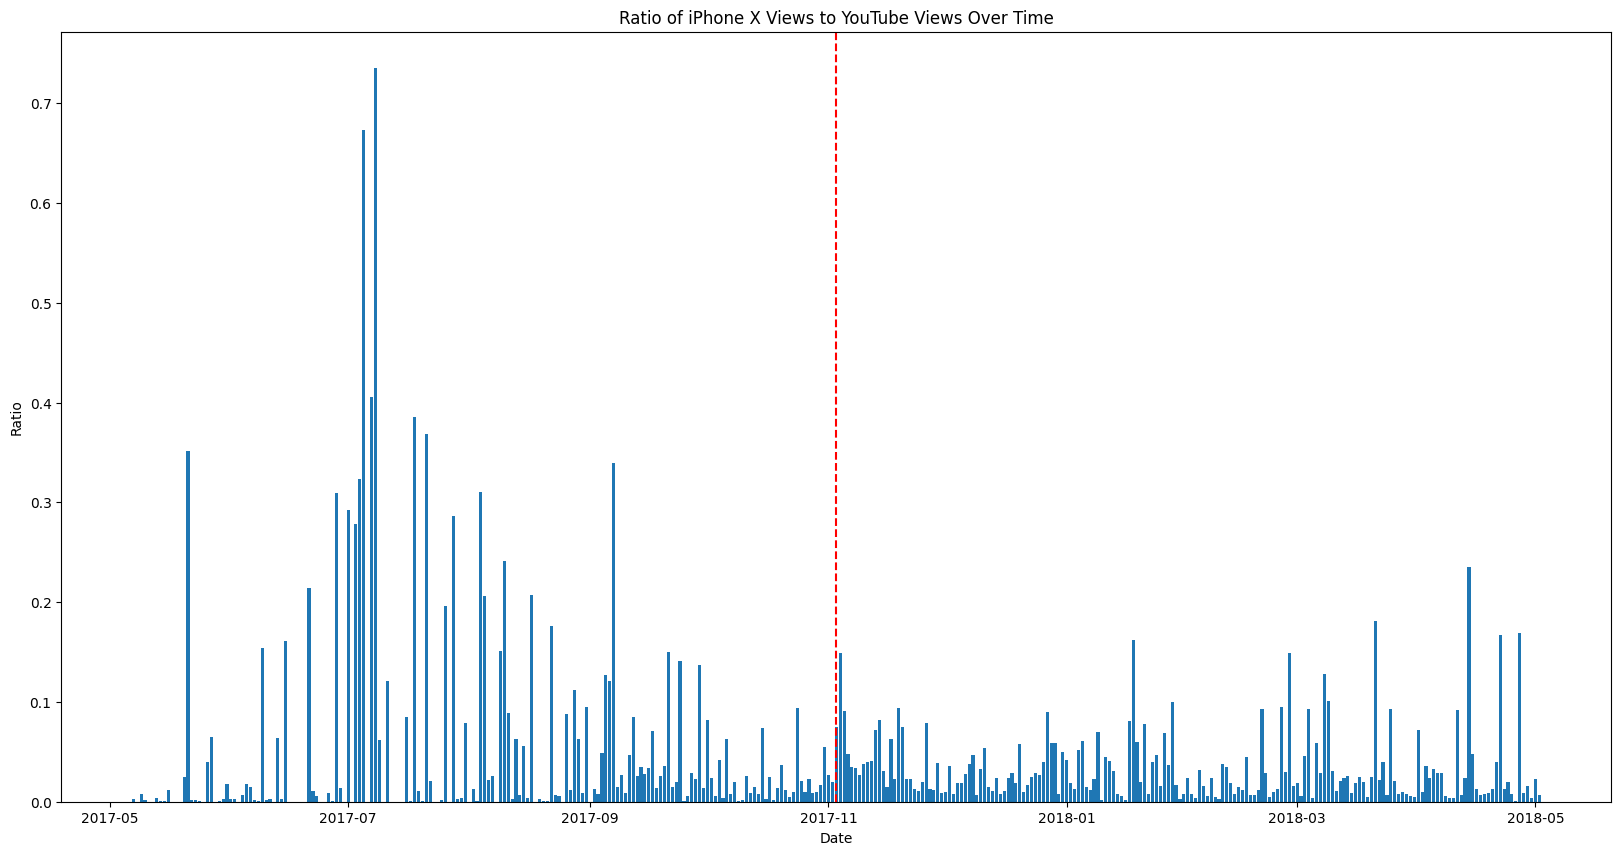

In [14]:
# plot the ratio over time
release_date = datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date()
plt.figure(figsize=(20,10))
plt.bar(merged_df.index, merged_df["ratio"])
plt.axvline(x=release_date, color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.title("Ratio of iPhone X Views to YouTube Views Over Time")
plt.show()


As we can see from the above plot, July 2017, September 2017 and November 2017 are all months with very high user interaction with videos about the iPhone.\
Indeed, in July, upwards of 70% of total views on the platfrom were directed towards videos about the iPhone.\
40%, in September and 15% in November.\
These months are all important with respect to the iPhone X, in fact, July 2017 came just after WWDC 2017, meaning that rumors about the iPhone X were starting to spread.\
September 2017 is the month where iPhone X was announced and November 2017 is the month where the iPhone X was released.\
We can thus conclude that the Youtube platform is most active around one month before the release of a product and at the time of its release.

### 1.2- Number of videos released about iPhone X and views generated

In [16]:
with open('data/yt_tech_metadata.pickle', 'rb') as f:
    items_dfs = pickle.load(f)

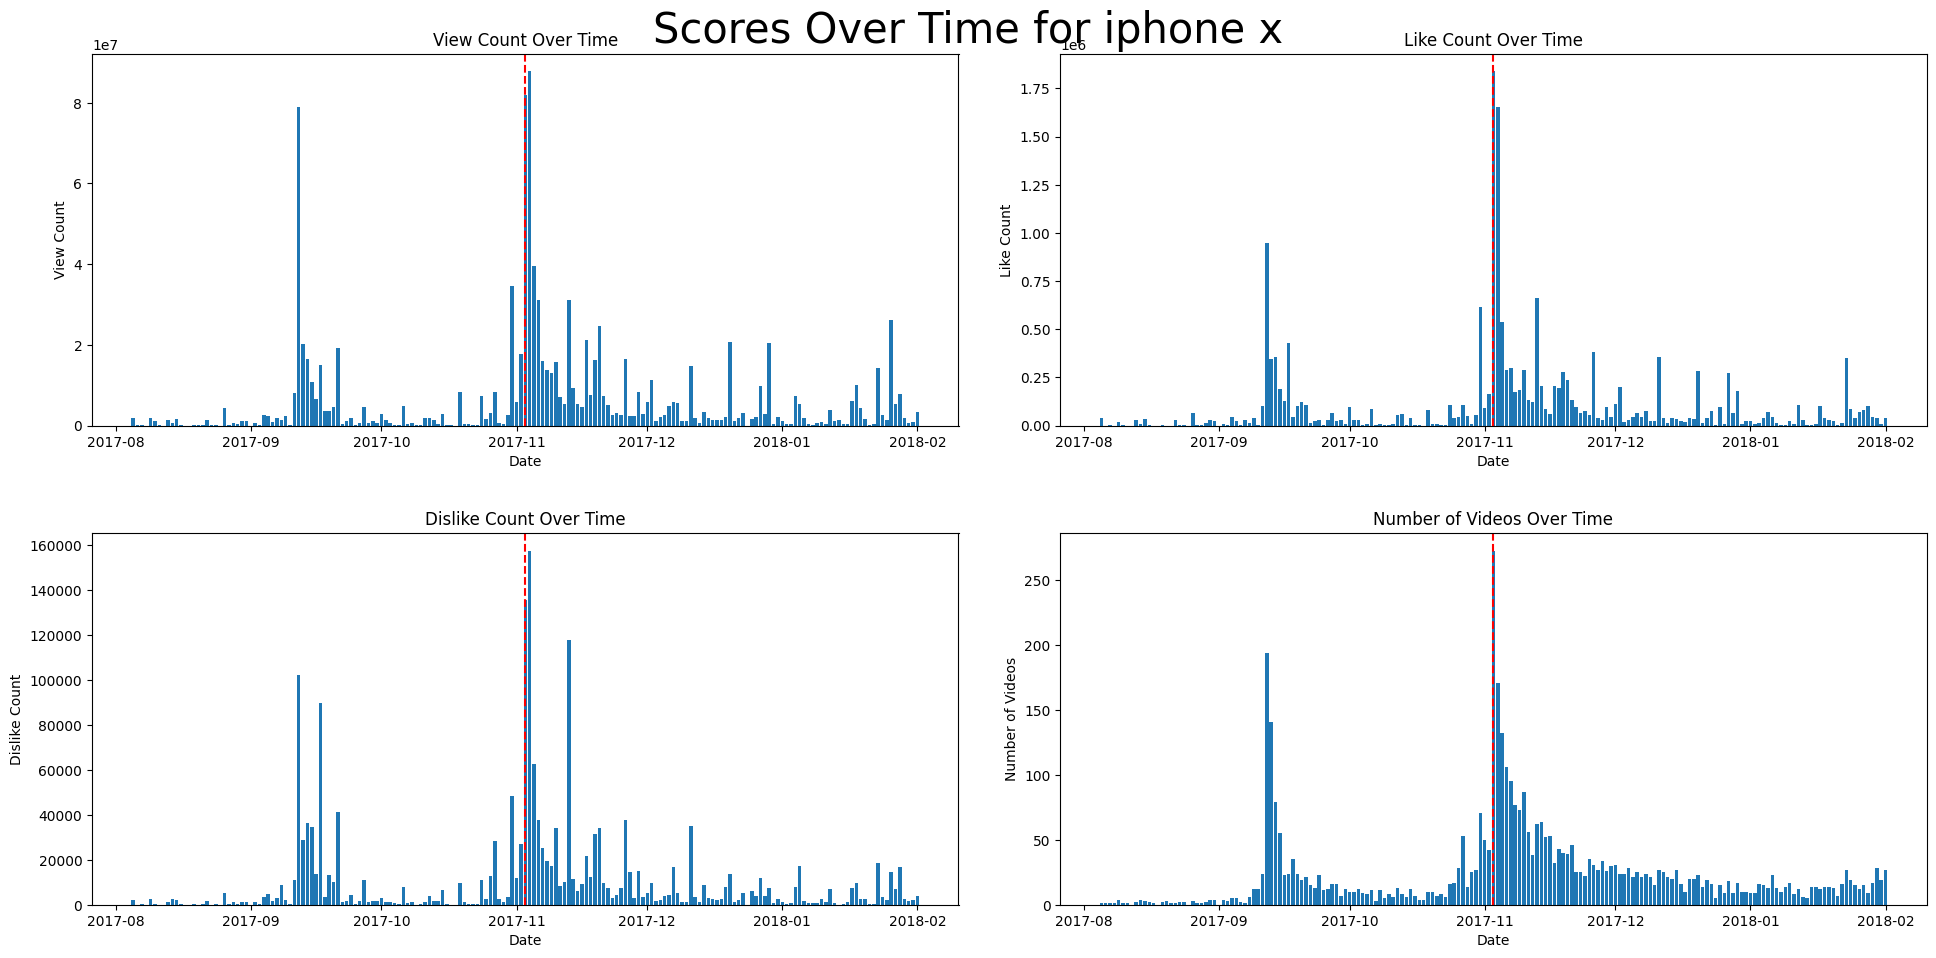

In [25]:
iphone_df = score_per_day(items_dfs['iphone x'], 'iphone x', datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date())
release_date = datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date()
plot_scores(iphone_df, release_date, 'iphone x')

We can once again clearly see once again that the number of views and videos released about the iPhone X reach peaks in September and November 2017.\
We can thus conclude that the Youtube platform is most active around one month before the release of a product and at the time of its release.\
Having concluded this, we would like to know what topics are the most discussed in the videos about the iPhone. during these two periods.

***
## 2- Topics discussed in videos about the iPhone
***

In [18]:
iphone_df = items_dfs['iphone x']
iphone_df["upload_date"] = pd.to_datetime(iphone_df["upload_date"])

# convert upload_date to date
iphone_df["upload_date"] = iphone_df["upload_date"].dt.date

# split into release and pre-release
pre_release = iphone_df[(iphone_df["upload_date"] <= release_date - datetime.timedelta(days=60))]
release = iphone_df[(iphone_df["upload_date"] >= release_date - datetime.timedelta(days=30)) & (iphone_df["upload_date"] <= release_date + datetime.timedelta(days=30))]

# keep only top 30% most viewed videos
pre_release = pre_release.sort_values(by="view_count", ascending=False)
pre_release = pre_release.iloc[:int(len(pre_release) * 0.3)]
release = release.sort_values(by="view_count", ascending=False)
release = release.iloc[:int(len(release) * 0.3)]

In [19]:
get_lda_topics(pre_release, 3, 10)

LDA Topics:
(0, '0.139*"leak" + 0.100*"latest" + 0.074*"hand" + 0.072*"plus" + 0.071*"model" + 0.070*"final" + 0.070*"unboxing" + 0.070*"edition" + 0.069*"clone" + 0.041*"gold"')
(1, '0.114*"hand" + 0.085*"prototype" + 0.076*"color" + 0.076*"apple" + 0.075*"new" + 0.068*"secret" + 0.056*"leak" + 0.051*"feature" + 0.051*"unboxing" + 0.045*"model"')
(2, '0.185*"leak" + 0.108*"feature" + 0.061*"experiment" + 0.061*"1000" + 0.061*"mph" + 0.061*"paintball" + 0.061*"diy" + 0.059*"bad" + 0.059*"news" + 0.036*"final"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.109826 -0.002037       1        1  36.969083
0     -0.057868 -0.055773       2        1  33.200639
1     -0.051958  0.057810       3        1  29.830277, topic_info=          Term      Freq     Total Category  logprob  loglift
12      latest  3.000000  3.000000  Default  24.0000  24.0000
17       color  2.000000  2.000000  Default  23.0000  23.0000
18         new  2.000000  2.000000  Default  22.0000  22.0000
9      feature  4.000000  4.000000  Default  21.0000  21.0000
3      edition  2.000000  2.000000  Default  20.0000  20.0000
..         ...       ...       ...      ...      ...      ...
23   paintball  0.275392  2.246739   Topic3  -4.3974  -0.8894
19        1000  0.275314  2.246572   Topic3  -4.3977  -0.8896
21  experiment  0.274889  2.246251   Topic3  -4.3992  -0.8910
4        final  0.300497  3.054579   Topic3  -4.3102  -1.1093
12      latest  0.302968  3.086922   Topic3  -4.3020  -1.1117

[96 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
19        1  0.890245        1000
10        1  0.332163       apple
10        3  0.664327       apple
15        1  0.889707         bad
0         2  0.652976       clone
0         3  0.326488       clone
17        3  0.882595       color
20        1  0.890104         diy
3         2  0.865707     edition
21        1  0.890373  experiment
9         1  0.667797     feature
9         3  0.222599     feature
4         1  0.327377       final
4         2  0.654755       final
14        2  0.437019        gold
14        3  0.437019        gold
6         1  0.187991        hand
6         2  0.375983        hand
6         3  0.563974        hand
12        2  0.647895      latest
7         1  0.508434        leak
7         2  0.305060        leak
7         3  0.101687        leak
13        2  0.652601       model
13        3  0.326300       model
22        1  0.890234         mph
18        3  0.882320         new
16        1  0.889740        news
23        1  0.890179   paintball
8         2  0.652417        plus
8         3  0.326208        plus
2         1  0.264254   prototype
2         2  0.264254   prototype
2         3  0.528508   prototype
5         2  0.437123    revealed
5         3  0.437123    revealed
11        3  0.881790      secret
1         1  0.262552    unboxing
1         2  0.525103    unboxing
1         3  0.262552    unboxing, R=24, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

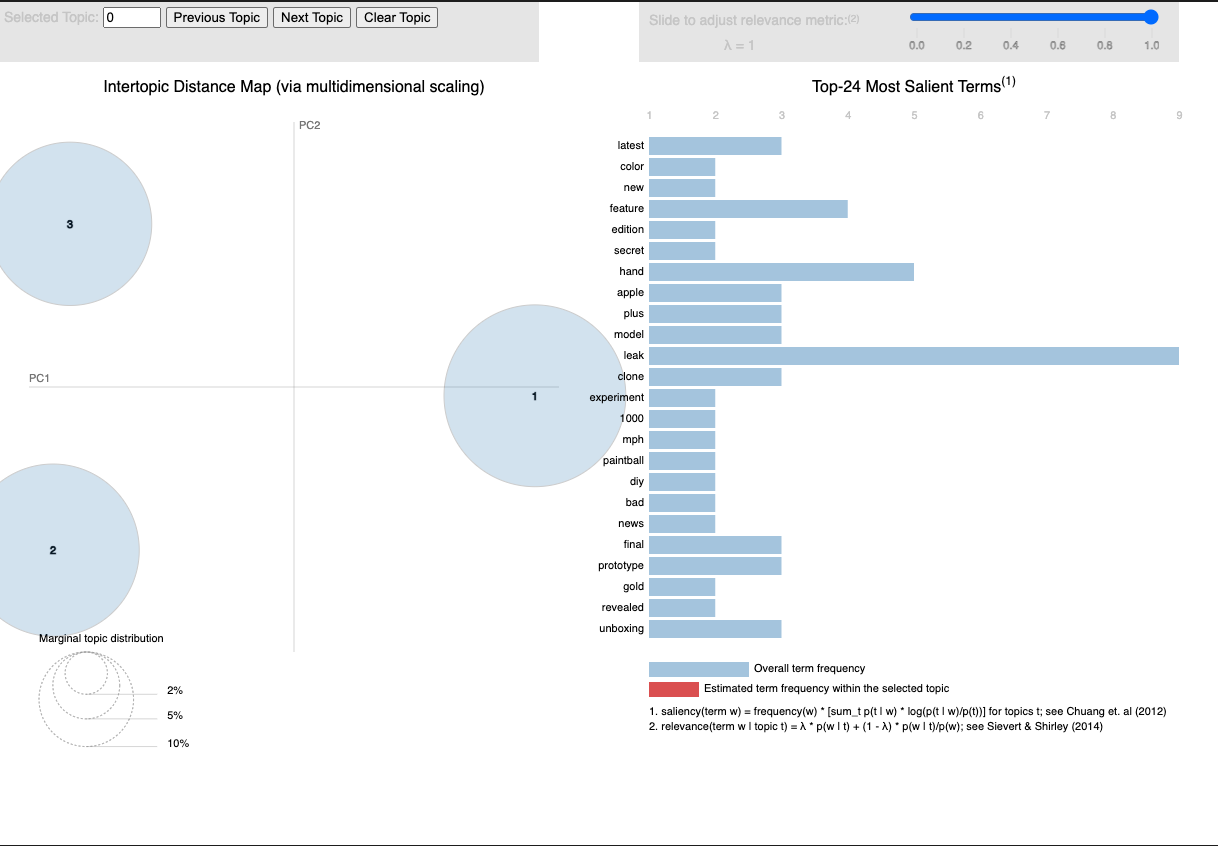

In [22]:
Image(filename='pre-release.png')

In [20]:
get_lda_topics(release, 3, 10)

LDA Topics:
(0, '0.064*"test" + 0.046*"apple" + 0.033*"speed" + 0.031*"review" + 0.028*"plus" + 0.028*"camera" + 0.024*"case" + 0.021*"unboxing" + 0.020*"galaxy" + 0.019*"note"')
(1, '0.045*"unboxing" + 0.026*"face" + 0.022*"apple" + 0.018*"new" + 0.017*"hand" + 0.016*"pocketnow" + 0.015*"space" + 0.014*"daily" + 0.012*"comparison" + 0.011*"samsung"')
(2, '0.042*"review" + 0.023*"first" + 0.018*"test" + 0.017*"top" + 0.016*"case" + 0.015*"unboxing" + 0.015*"apps" + 0.015*"galaxy" + 0.014*"prank" + 0.012*"samsung"')


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.090988  0.034019       1        1  45.426286
2     -0.010821 -0.083961       2        1  28.150259
1     -0.080167  0.049943       3        1  26.423455, topic_info=         Term       Freq      Total Category  logprob  loglift
41      speed  37.000000  37.000000  Default  30.0000  30.0000
11     review  62.000000  62.000000  Default  29.0000  29.0000
14       test  83.000000  83.000000  Default  28.0000  28.0000
5    unboxing  59.000000  59.000000  Default  27.0000  27.0000
83       hand  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
19      first   4.706534  24.414232   Topic3  -4.8797  -0.3153
60      trick   4.333891  18.259471   Topic3  -4.9622  -0.1073
25     galaxy   4.764453  35.615026   Topic3  -4.8675  -0.6807
63       plus   4.801538  37.721713   Topic3  -4.8598  -0.7304
114      case   4.803550  40.568388   Topic3  -4.8593  -0.8027

[202 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
166       3  0.716430        000
32        2  0.215889       1000
32        3  0.647667       1000
67        1  0.256529  accessory
67        2  0.256529  accessory
...     ...       ...        ...
7         2  0.766119    walmart
338       2  0.765934     winner
191       1  0.785347   wireless
191       3  0.261782   wireless
348       3  0.797453       work

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

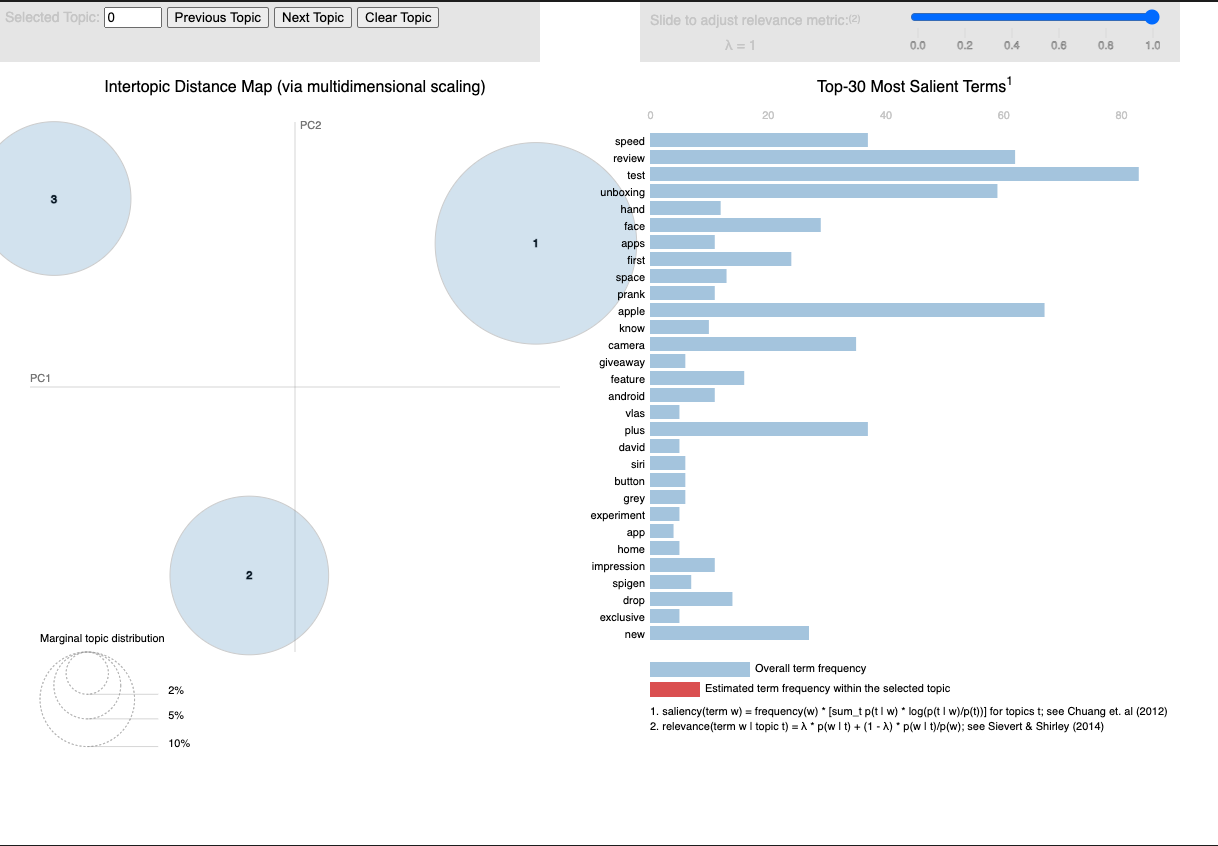

In [23]:
Image(filename='release.png')

As we can see, topics discussed in the pre-release period and during the release period are very different.\
In pre-release period, the videos mostly talk about:
- Leaking information about the iPhone X
- Unboxing of clones or possible prototypes of the iPhone X
- Possible features of the iPhone X

And during the release period, the videos mostly talk about:
- Unboxing of the iPhone X
- Reviews of the iPhone X
- Comparisons between the iPhone X and other phones
- Testing different features of the iPhone X such as the camera, the screen, the battery, etc.